# ATOC4815/5815: Intro to Xarray

Author: Clairy Reiher

Last updated: December 22, 2024

This is a very brief intro to the module Xarray to demonstrate how powerful of a package it is for working with gridded data (i.e., output from reanalysis, satellite data, output from weather/climate models, etc.).

### Package Installation

To install Xarray using pip or Anaconda, run one of these commands in a terminal window:

`conda install -c conda-forge xarray`

or

`pip install xarray` (if this doesn't work, you can also try `python -m pip install xarray`)

To run the code in this notebook, you must also have installed the netCDF4 Python package. If you have not already installed netCDF4, then run one of the following commands in a terminal window as well:

`conda install conda-forge::netcdf4`

or 

`pip install netCDF4` (if this doesn't work, you can also try `python -m pip install netCDF4`)

### File Download

For this demonstration, we'll work with output from NASA's [MERRA-2 Reanalysis](`https://gmao.gsfc.nasa.gov/reanalysis/merra-2/`) that we've discussed in class before. I have uploaded the file to Google Drive, where it can be downloaded at this [link](https://drive.google.com/file/d/1odvBwOQLD2b6cx5Z-Q7BOuiTl2MlYC8D/view?usp=drive_link). This file contains data at each hour on the day of July 2, 2018.

In [1]:
# Import modules we need
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime 

Opening a netCDF file and viewing its contents is really easy with Xarray.

In [3]:
# Open and load in the netCDF file
file = xr.open_dataset('./MERRA2_400.inst1_2d_asm_Nx.20180702.nc')

The contents of the file print out really easily, and in JupyterLab, you can interact with the output to open up all the different variables contained in the netCDF file. 

When you run the code cell below, you'll be able to see that there are a few different variables in the file ("T2M," which is 2-meter temperature, "U10M", which is the component of the 10-meter wind vector that points in the direction of the longitude, etc.). Each of these variables have three coordinates:
- `lon`: longitude, running from -180º to 180º
- `lat`: latitude, running from -90º to 90º
- `time`: hourly times, running from 00:00 UTC to 23:00 UTC on 2018-07-02 

In [4]:
# Print out the contents of the netCDF file
file

<xarray.Dataset> Size: 100MB
Dimensions:  (lon: 576, lat: 361, time: 24)
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time     (time) datetime64[ns] 192B 2018-07-02 ... 2018-07-02T23:00:00
Data variables:
    SLP      (time, lat, lon) float32 20MB ...
    T2M      (time, lat, lon) float32 20MB ...
    TS       (time, lat, lon) float32 20MB ...
    U10M     (time, lat, lon) float32 20MB ...
    V10M     (time, lat, lon) float32 20MB ...
Attributes: (12/30)
    History:                           Original file generated: Fri Jul 13 14...
    Comment:                           GMAO filename: d5124_m2_jan10.inst1_2d...
    Filename:                          MERRA2_400.inst1_2d_asm_Nx.20180702.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/3Z173KIE2TPD
    RangeBeginningDate:                2018-07-02
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2018-07-02
    RangeEndingTime:                   23:00:00.000000

There are two important data types in Xarray:
1. **Dataset** - contains multiple variables in one object
2. **DataArray** - contains only one variable per object

A Dataset is basically a bunch of DataArrays contained in one object together. When we opened the netcdf file above, we created a Dataset named `file`. But now, let's create a single DataArray object by extracting one of the variables contained in `file`. There's two options for the syntax to do this. For example, if we want to extract 2-meter temperature:
1. `t2m = file['T2M']`
2. `t2m = file.t2m`

`t2m` in this case would be a DataArray object.

In [5]:
# Load in a single variable and print out its contents
t2m = file['T2M']
t2m

<xarray.DataArray 'T2M' (time: 24, lat: 361, lon: 576)> Size: 20MB
[4990464 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time     (time) datetime64[ns] 192B 2018-07-02 ... 2018-07-02T23:00:00
Attributes:
    long_name:       2-meter_air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    standard_name:   2-meter_air_temperature
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

Indexing in Xarray is super easy with the `sel()` command. Suppose we want to extract the 2-meter temperature at all times at the latitude and longitude of a single point (like Boulder, Colorado, for example).

In [6]:
# Select temperature at a single location (i.e., at a single latitude and longitude)
lat_point = 40.0
lon_point = -105.0
t2m_point = t2m.sel(lat = lat_point, lon = lon_point)

The code cell above searched for a latitude and longitude exactly equal to a latitude and longitude that exists in the list of latitudes and longitudes available for `t2m`. But if you put in a more precise latitude and longitude for Boulder, like 40.015 for the latitude and -105.27 for the longitude, the code would have thrown an error. 

Here's how you tell Xarray to pull the 2-meter temperature from the *closest* latitude and *closest* longitude to a point you have in mind.

In [7]:
lat_point = 40.02
lon_point = -105.27
t2m_point = t2m.sel(lat = lat_point, lon = lon_point, method='nearest')

Now let's plot a *really quick* time series of 2-meter temperature using `t2m_point`.

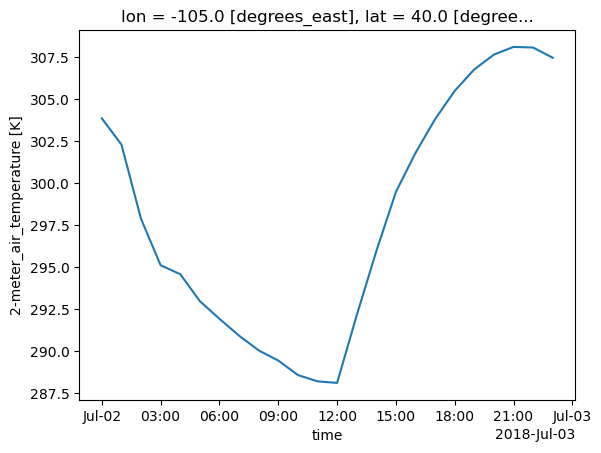

In [8]:
t2m_point.plot()

Okay that was crazy easy, but the plot isn't the prettiest. Let's take our time in the code to make it prettier.

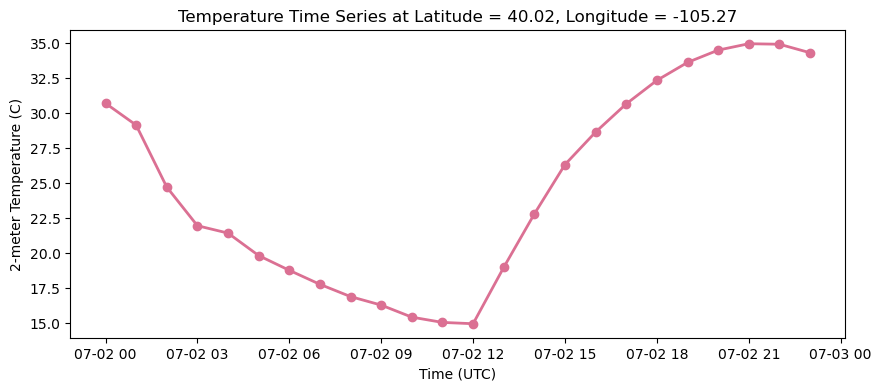

In [9]:
# Make a new figure with a specific width and height
fig = plt.figure(figsize = (10,4))

# Plot temperature vs. time
# Convert the temperature from Kelvin to Celcius while we plot
plt.plot(t2m_point.time, t2m_point-273.15, color='palevioletred', marker='o', linewidth=2)

# Add labels
plt.xlabel('Time (UTC)')
plt.ylabel('2-meter Temperature (C)')
plt.title('Temperature Time Series at Latitude = '+format(lat_point)+', Longitude = '+format(lon_point))

# Tell Python we're done with the figure
plt.show()

Suppose we wanted to select 2-meter temperature at a single time (12:00 UTC on 2018-07-02, for example) for just North America (which is contained approximately within latitudes 84º - 6º, and -170º - -7º). Let's do that and then plot it using the quick and easy method.

In [10]:
# Select 2m temperature just for North America
t2m_na = t2m.sel(lat = slice(6.0, 84.0), lon = slice(-170.0, -7.0))

# Select it at a single hour
hour = datetime(2018,7,2,12)
t2m_na_onetime = t2m_na.sel(time = hour)

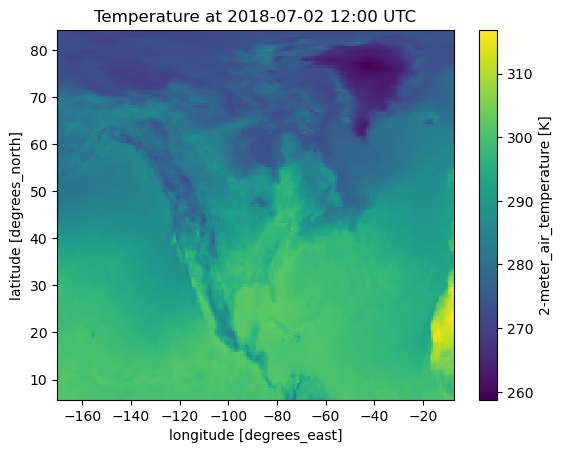

In [11]:
# Make a really quick plot of the temperature
t2m_na_onetime.plot()
plt.title('Temperature at '+hour.strftime('%Y-%m-%d %H:00 UTC'))
plt.show()

Lastly, what if we wanted to make a plot of the 2-meter temperature across North America again, but this time averaged across all times on July 2, 2018? Xarray comes with a bunch of math functions, like `mean()` for example. Let's make a more beautiful with plot this time.

In [12]:
# Average North American temperatures across the time dimension
t2m_na_mean = t2m_na.mean(dim = 'time')

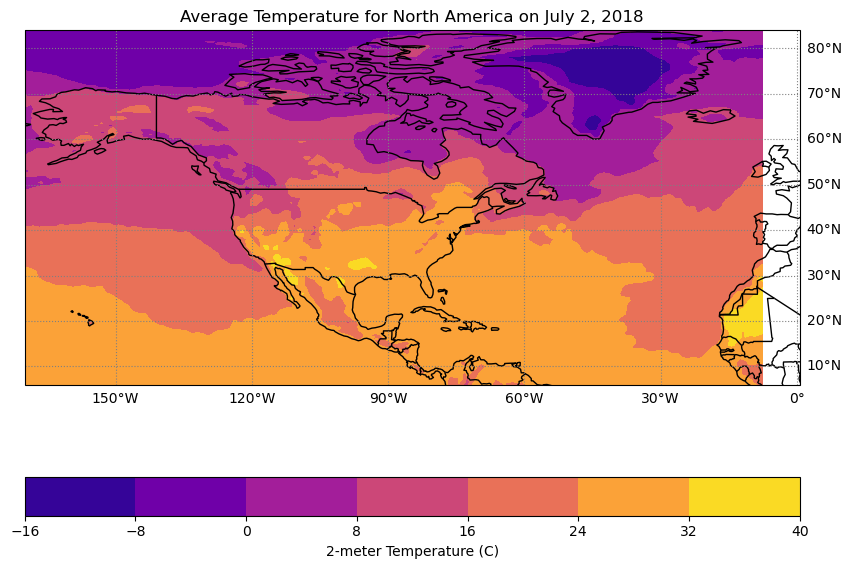

In [13]:
# Make a new figure and set of axes
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = -90))

# Add continental and country boundaries
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
              
# Make a contour plot of temperature
# Convert it to Celcius again before plotting
contf = ax.contourf(t2m_na_mean.lon, 
                    t2m_na_mean.lat, 
                    t2m_na_mean - 273.15, 
                    cmap=cm['plasma'],
                    transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(contf,orientation='horizontal')
cbar.set_label('2-meter Temperature (C)')

# Add gridlines
gridlines = ax.gridlines(color='gray',ls='dotted',draw_labels=True)
gridlines.top_labels  = False
gridlines.left_labels = False

# Add title
plt.title('Average Temperature for North America on July 2, 2018')

plt.show()

Some other brief notes if you want to learn more about Xarray:
- Instead of using coordinate values to index with `sel()`, you can use `isel()` to index using the indices of the coordinate values in their respective arrays
    - Example: to grab 2-meter temperature at the first time in the file, use `t2m.isel(time = 0)`
- Convert an Xarray DataArray to a Numpy array using `.values`
    - Example: `t2m.values` returns `t2m` as a Numpy array
- Xarray has a friendly way to interpolate datasets to new coordinates
    - Example: `t2m.interp(lat=40.2)`
    - Requires the [SciPy package](https://scipy.org/install/) to be installed
    - Read more [here](https://docs.xarray.dev/en/stable/user-guide/interpolation.html)
- Xarray has a useful function `where()` that offers functionality similar to Numpy's `where()` and lets you mask out values with NaNs
    - Read more [here](https://docs.xarray.dev/en/stable/generated/xarray.where.html)
    - There's also version that is a method for DataArrays, as shown [here](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html)